In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
from PIL import Image
import torch
from torch import nn
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, ConcatDataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pickle
import warnings
import albumentations as A

warnings.filterwarnings('ignore')

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# EDA

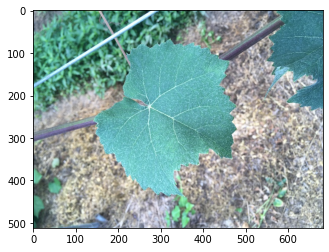

In [2]:
sample = glob('data/train/*')[np.random.randint(0, 1000)]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
sample_csv = pd.read_csv(r'data/train/10045/10045.csv')
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-09-15 16:10:00,28.4,28.6,28.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2021-09-15 16:00:00,29.2,29.5,28.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2021-09-15 15:50:00,29.4,29.6,29.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2021-09-15 15:40:00,29.1,29.2,28.9,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2021-09-15 15:30:00,29.0,29.2,28.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2021-09-13 16:00:00,28.3,28.6,28.1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
290,2021-09-13 15:50:00,28.6,28.6,28.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
291,2021-09-13 15:40:00,28.4,28.6,28.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
292,2021-09-13 15:30:00,28.9,29.1,28.7,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [4]:
# # image
# plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
# plt.show()

In [5]:
# json
sample_json

{'description': {'date': '20210714',
  'image': '11936.jpg',
  'task': 0,
  'width': 682,
  'time': '0954',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': '00',
  'grow': 24,
  'bbox': [{'x': 141.40952587632276,
    'h': 373.02856316137564,
    'y': 67.65714389054233,
    'w': 338.8952546296296}],
  'part': [],
  'risk': 0,
  'crop': 6}}

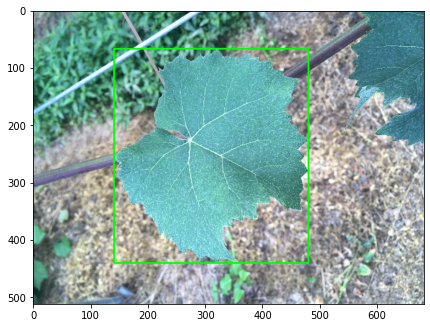

In [6]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

In [7]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
'내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'] #, '내부 CO2 평균', '내부 CO2 최고', '내부 CO2 최저']

csv_files = sorted(glob('data/train/*/*.csv'))

# 환경 데이터 통계량 계산 for MinMax Scaling

In [8]:
# ## ADDED

# lens = []
# total_sum = 0
# total_cnt = 0

# temp_csv = pd.read_csv(csv_files[0])[csv_features]
# temp_csv = temp_csv.replace('-',np.nan).dropna() 
# temp_csv = temp_csv.astype(float)
# max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
# total_sum += temp_csv.sum().to_numpy()
# total_cnt+=1

# # feature 별 최대값, 최솟값 계산
# for csv in tqdm(csv_files[1:]):
#     temp_csv = pd.read_csv(csv)[csv_features]
#     temp_csv = temp_csv.replace('-', np.nan).dropna()
#     lens.append(len(temp_csv))
#     if len(temp_csv) == 0:
#         continue    # nan값이면 최대, 최솟값 계산하지 않음
#     temp_csv = temp_csv.astype(float)
#     temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
#     temp_sum = temp_csv.sum().to_numpy()
#     temp_cnt = len(temp_csv)

#     total_sum += temp_sum
#     total_cnt += temp_cnt

#     max_arr = np.max([max_arr,temp_max], axis=0)
#     min_arr = np.min([min_arr,temp_min], axis=0)

# # feature 별 최대값, 최솟값 dictionary 생성
# csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}

# # ADDED # feature 별 평균의 dict 생성 
# csv_means = total_sum/total_cnt
# csv_feature_mean_dict = {csv_features[i]:csv_means[i] for i in range(len(csv_features))}

# # save data
# with open('csv_feature_dict.pkl','wb') as fw:
#     pickle.dump(csv_feature_dict, fw)

# with open('csv_feature_mean_dict.pkl','wb') as fw:
#     pickle.dump(csv_feature_mean_dict, fw)

In [9]:
# temp_csv

In [10]:
# pd.DataFrame(lens).value_counts()

In [11]:
# load data

with open('csv_feature_dict.pkl', 'rb') as fr:
    csv_feature_dict = pickle.load(fr)

with open('csv_feature_mean_dict.pkl', 'rb') as fr:
    csv_feature_mean_dict = pickle.load(fr)

print(csv_feature_dict)
print(csv_feature_mean_dict)

{'내부 온도 1 평균': [3.4, 47.3], '내부 온도 1 최고': [3.4, 47.6], '내부 온도 1 최저': [3.3, 47.0], '내부 습도 1 평균': [23.7, 100.0], '내부 습도 1 최고': [25.9, 100.0], '내부 습도 1 최저': [0.0, 100.0], '내부 이슬점 평균': [0.1, 34.5], '내부 이슬점 최고': [0.2, 34.7], '내부 이슬점 최저': [0.0, 34.4]}
{'내부 온도 1 평균': 20.68236712855918, '내부 온도 1 최고': 20.826133211812305, '내부 온도 1 최저': 20.532250333338887, '내부 습도 1 평균': 79.30295313001012, '내부 습도 1 최고': 80.1790475226017, '내부 습도 1 최저': 78.42933861049711, '내부 이슬점 평균': 16.663928617641908, '내부 이슬점 최고': 16.95606800677366, '내부 이슬점 최저': 16.373912752395313}


# CustomDataset 제작

In [12]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'} 

In [13]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'

In [14]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

# Augmentation

In [15]:
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose([
    A.Resize(380, 380, interpolation=cv2.INTER_AREA),
    A.HorizontalFlip(),
    A.GaussNoise(p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit = 3, p = 0.2),
        A.MedianBlur(blur_limit = 3, p = 0.1),
        A.Blur(blur_limit = 3, p = 0.1),
        ], p = 0.2),
    A.ShiftScaleRotate(rotate_limit = 30),
    A.OneOf([
        A.OpticalDistortion(p = 1.0),
        A.GridDistortion(p = 1.0),
        ], p = 0.3),
    A.OneOf([
        A.CLAHE(clip_limit = 2),
        A.RandomBrightnessContrast(),
        ], p = 0.3),
    A.HueSaturationValue(p = 0.3),
    # A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    A.Normalize(),
    ToTensorV2()
])

else_transform = A.Compose([
    A.Resize(380, 380, interpolation=cv2.INTER_AREA),
    # A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    A.Normalize(),
    ToTensorV2()
])

In [16]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = max_len
        self.label_encoder = label_encoder
        # self.img_transform = transform # ADDED

    def __len__(self):
        return len(self.files)

    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('\\')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]

            # ADDED 
            # 쓸 feature에 대해서만 평균값으로 imputation 진행 
            for key in self.csv_feature_dict.keys():
                df[key] = df[key].replace('-', csv_feature_mean_dict[key])
            # df = df.replace('-', 0) ###Original###

            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:] # max_len 까지만 df 사용, 그 이전은 0  
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        # print(len(csv_feature))

        # image
        image_path = f'{file}/{file_name}.jpg'

        img = Image.open(image_path)
        img = np.asarray(img)
    
        if self.mode != 'test':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
                
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            if self.mode == 'train':
                img = train_transform(image=img)['image']
                
            elif self.mode == 'val':
                img = else_transform(image=img)['image']

            return {
                'img' : img,
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }

        else:

            img = else_transform(image=img)['image']
            return {
                'img' : img,
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# Hyperparameter

In [17]:
device = torch.device("cuda:0")
train_batch_size = 16
else_batch_size = 32
class_n = len(label_encoder)
learning_rate = 1e-5 * train_batch_size
embedding_dim = 512     # RNN hidden
num_features = len(csv_feature_dict)
max_len = 144

# CNN

# RNN
rnn_fc_dim = 1000
fc_dropout_rate = 0.2
epochs = 100

# Save 설정
save_name = 'JS_effb4+LSTM_v2'
save_path = f'models/{save_name}.pt'
print(f'class수 : {class_n}')
print(f'feature 수: {num_features}')
print(save_name)
print(save_path)

class수 : 111
feature 수: 9
JS_effb4+LSTM_v2
models/JS_effb4+LSTM_v2.pt


# 데이터셋 구성

In [18]:
train = sorted(glob('data/train/*'))
test = sorted(glob('data/test/*'))

labelsss = pd.read_csv('data/train_gt.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [19]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val, mode = 'val')
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=else_batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=else_batch_size, shuffle=False)

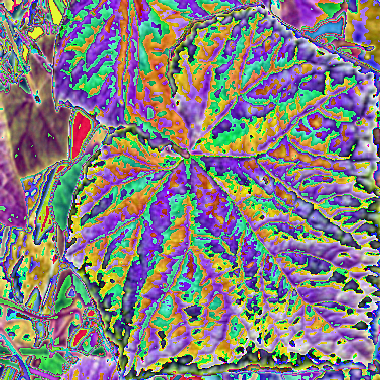

In [20]:
toimage = transforms.ToPILImage()
toimage(train_dataset[np.random.randint(1, 1000)]['img'])

# 모델

## 이미지 분류 모델 : EfficientNetb4

In [21]:
from torchvision.models import efficientnet_b4

class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate=0.2):
        super(CNN_Encoder, self).__init__()
        self.model = efficientnet_b4(pretrained=True)    # (input, output) = (380, 1792)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [22]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, rnn_fc_dim) # csv에서 사용할 Feature 수 * embedding차원 
        self.final_layer = nn.Linear(1000+rnn_fc_dim, class_n) # cnn out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp) # hidden dim : (Batch, csv_feature, embedding_dim)
        hidden = hidden.view(hidden.size(0), -1)    # (Batch, num_features*embedding_dim)
        hidden = self.rnn_fc(hidden)    # (, 1000)

        fc_input = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        output = self.final_layer(fc_input)
        output = self.dropout(output)
        return output

## 앙상블

In [23]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)  # concat - 1000+1000
        
        return output

In [24]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=fc_dropout_rate)
model = model.to(device)

In [25]:
# hidden dim : (Batch, csv_feature, embedding_dim)
# final output : (Batch, n_class)
# model = model.cpu()
# sample_batch = next(iter(train_dataloader))
# sample_img = sample_batch['img']
# sample_csv = sample_batch['csv_feature']
# sample_out = model(sample_img, sample_csv)
# sample_out
# OUT SHAPE : (16, 111)
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x2000 and 2792x111)

In [26]:
import gc
gc.collect()

6103

# 학습

## Loss, LR Scheduler

In [27]:
import torch.nn.functional as F

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [28]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0=100, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8)
criterion = FocalLoss()
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=25, eta_max=learning_rate, T_up=5, gamma=0.8)

In [30]:
import torch.nn as nn

def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train(model, loader, epoch, nb_epochs):
    print(f'Epoch {epoch+1}/{nb_epochs}')
    running_loss = 0.0
    running_score = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    scheduler.step()

    for idx, batch in enumerate(tqdm(loader)):
        img = batch['img'].to(device)
        csv_feature = batch['csv_feature'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)

        scaler.scale(loss).backward() # ADDED - mixed precision + gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        scaler.step(optimizer)
        scaler.update()

        score = accuracy_function(label, output)
        pred = torch.argmax(output, dim=1)

        running_loss += loss.item() 
        running_score ++ score
        running_corrects += torch.sum(label==pred)
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_score = running_corrects / len(loader.dataset)
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('F1_score/train', epoch_score, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    print(f'Train loss: {epoch_loss:.6f}, Train F1: {epoch_score:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}')
    # print(f"{running_corrects}/{len(loader.dataset)} correct")

def validate(model, loader, epoch, nb_epochs):
    running_loss = 0.0
    running_score = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].to(device)
            csv_feature = batch['csv_feature'].to(device)
            label = batch['label'].to(device)
            output = model(img, csv_feature)
            loss = criterion(output, label)
            score = accuracy_function(label, output)
            pred = torch.argmax(output, dim=1)
            
            running_loss += loss.item() 
            running_score += score
            running_corrects += torch.sum(label==pred)
            
        epoch_loss = running_loss / len(loader.dataset)
        epoch_score = running_corrects / len(loader.dataset)
        writer.add_scalar('Loss/valid', epoch_loss, epoch)
        writer.add_scalar('F1_score/valid', epoch_score, epoch)
        # writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
        print("Val loss: {:.6f}, Val F1: {:.6f}".format(epoch_loss, epoch_score)) # lr: {optimizer.param_groups[0]["lr"]:.6f}')
        print(f"{running_corrects}/{len(loader.dataset)} correct")

        epoch_score = epoch_score.detach().cpu().numpy()
        val_score_list.append(epoch_score)
        
        if np.max(val_score_list) == val_score_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            torch.save(model.state_dict(), save_path)


In [31]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)
val_score_list = []

for epoch in range(epochs):
    train(model, train_dataloader, epoch, epochs)
    validate(model, val_dataloader, epoch, epochs) 

Epoch 1/100


100%|██████████| 289/289 [04:11<00:00,  1.15it/s]


Train loss: 0.149053, Train F1: 0.380663, lr: 0.000032
Val loss: 0.025277, Val F1: 0.660312
762/1154 correct
Epoch 2/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.077176, Train F1: 0.579233, lr: 0.000064
Val loss: 0.008157, Val F1: 0.798960
922/1154 correct
Epoch 3/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.055815, Train F1: 0.637980, lr: 0.000096
Val loss: 0.002242, Val F1: 0.863951
997/1154 correct
Epoch 4/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.038417, Train F1: 0.703013, lr: 0.000128
Val loss: 0.000730, Val F1: 0.901213
1040/1154 correct
Epoch 5/100


100%|██████████| 289/289 [03:21<00:00,  1.44it/s]


Train loss: 0.031176, Train F1: 0.737481, lr: 0.000160
Val loss: 0.000273, Val F1: 0.937608
1082/1154 correct
Epoch 6/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.026374, Train F1: 0.754390, lr: 0.000159
Val loss: 0.000337, Val F1: 0.926343
1069/1154 correct
Epoch 7/100


100%|██████████| 289/289 [03:21<00:00,  1.44it/s]


Train loss: 0.024102, Train F1: 0.770215, lr: 0.000156
Val loss: 0.000141, Val F1: 0.948007
1094/1154 correct
Epoch 8/100


100%|██████████| 289/289 [03:21<00:00,  1.44it/s]


Train loss: 0.022140, Train F1: 0.772166, lr: 0.000151
Val loss: 0.000103, Val F1: 0.956672
1104/1154 correct
Epoch 9/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.019823, Train F1: 0.788641, lr: 0.000145
Val loss: 0.000156, Val F1: 0.949740
1096/1154 correct
Epoch 10/100


100%|██████████| 289/289 [03:20<00:00,  1.44it/s]


Train loss: 0.019378, Train F1: 0.795361, lr: 0.000137
Val loss: 0.000060, Val F1: 0.963605
1112/1154 correct
Epoch 11/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.018108, Train F1: 0.804682, lr: 0.000127
Val loss: 0.000079, Val F1: 0.968804
1118/1154 correct
Epoch 12/100


100%|██████████| 289/289 [03:17<00:00,  1.47it/s]


Train loss: 0.016995, Train F1: 0.801864, lr: 0.000116
Val loss: 0.000069, Val F1: 0.968804
1118/1154 correct
Epoch 13/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.016806, Train F1: 0.809668, lr: 0.000105
Val loss: 0.000108, Val F1: 0.967071
1116/1154 correct
Epoch 14/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.016470, Train F1: 0.810102, lr: 0.000093
Val loss: 0.000113, Val F1: 0.972270
1122/1154 correct
Epoch 15/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.016718, Train F1: 0.810752, lr: 0.000080
Val loss: 0.000127, Val F1: 0.969671
1119/1154 correct
Epoch 16/100


100%|██████████| 289/289 [03:17<00:00,  1.46it/s]


Train loss: 0.015986, Train F1: 0.810969, lr: 0.000067
Val loss: 0.000094, Val F1: 0.974870
1125/1154 correct
Epoch 17/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.016802, Train F1: 0.804466, lr: 0.000055
Val loss: 0.000121, Val F1: 0.973137
1123/1154 correct
Epoch 18/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.018000, Train F1: 0.796445, lr: 0.000044
Val loss: 0.000110, Val F1: 0.975737
1126/1154 correct
Epoch 19/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.014673, Train F1: 0.815955, lr: 0.000033
Val loss: 0.000189, Val F1: 0.972270
1122/1154 correct
Epoch 20/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.016153, Train F1: 0.813787, lr: 0.000023
Val loss: 0.000155, Val F1: 0.971404
1121/1154 correct
Epoch 21/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.017836, Train F1: 0.801864, lr: 0.000015
Val loss: 0.000183, Val F1: 0.967938
1117/1154 correct
Epoch 22/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.015293, Train F1: 0.812486, lr: 0.000009
Val loss: 0.000256, Val F1: 0.971404
1121/1154 correct
Epoch 23/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.016805, Train F1: 0.805550, lr: 0.000004
Val loss: 0.000193, Val F1: 0.975737
1126/1154 correct
Epoch 24/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.016920, Train F1: 0.807284, lr: 0.000001
Val loss: 0.000200, Val F1: 0.977470
1128/1154 correct
Epoch 25/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.014830, Train F1: 0.820941, lr: 0.000000
Val loss: 0.000181, Val F1: 0.974003
1124/1154 correct
Epoch 26/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.015754, Train F1: 0.811836, lr: 0.000026
Val loss: 0.000221, Val F1: 0.971404
1121/1154 correct
Epoch 27/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.017772, Train F1: 0.801214, lr: 0.000051
Val loss: 0.000208, Val F1: 0.973137
1123/1154 correct
Epoch 28/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.015945, Train F1: 0.814437, lr: 0.000077
Val loss: 0.000208, Val F1: 0.973137
1123/1154 correct
Epoch 29/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.015072, Train F1: 0.820507, lr: 0.000102
Val loss: 0.000353, Val F1: 0.976603
1127/1154 correct
Epoch 30/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.016855, Train F1: 0.803815, lr: 0.000128
Val loss: 0.000275, Val F1: 0.972270
1122/1154 correct
Epoch 31/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.018854, Train F1: 0.802731, lr: 0.000127
Val loss: 0.000761, Val F1: 0.965338
1114/1154 correct
Epoch 32/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.017038, Train F1: 0.814004, lr: 0.000125
Val loss: 0.001116, Val F1: 0.964471
1113/1154 correct
Epoch 33/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.016223, Train F1: 0.814221, lr: 0.000121
Val loss: 0.000890, Val F1: 0.962738
1111/1154 correct
Epoch 34/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.016559, Train F1: 0.805983, lr: 0.000116
Val loss: 0.001139, Val F1: 0.974870
1125/1154 correct
Epoch 35/100


100%|██████████| 289/289 [03:21<00:00,  1.44it/s]


Train loss: 0.017075, Train F1: 0.807067, lr: 0.000109
Val loss: 0.001891, Val F1: 0.968804
1118/1154 correct
Epoch 36/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.014812, Train F1: 0.823325, lr: 0.000102
Val loss: 0.002344, Val F1: 0.965338
1114/1154 correct
Epoch 37/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.017770, Train F1: 0.816172, lr: 0.000093
Val loss: 0.001489, Val F1: 0.968804
1118/1154 correct
Epoch 38/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.015525, Train F1: 0.818339, lr: 0.000084
Val loss: 0.002373, Val F1: 0.969671
1119/1154 correct
Epoch 39/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.014218, Train F1: 0.829829, lr: 0.000074
Val loss: 0.004656, Val F1: 0.962738
1111/1154 correct
Epoch 40/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.015967, Train F1: 0.822458, lr: 0.000064
Val loss: 0.004978, Val F1: 0.971404
1121/1154 correct
Epoch 41/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.015645, Train F1: 0.818339, lr: 0.000054
Val loss: 0.003258, Val F1: 0.967071
1116/1154 correct
Epoch 42/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.015664, Train F1: 0.821591, lr: 0.000044
Val loss: 0.002535, Val F1: 0.968804
1118/1154 correct
Epoch 43/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.014340, Train F1: 0.819857, lr: 0.000035
Val loss: 0.003031, Val F1: 0.969671
1119/1154 correct
Epoch 44/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.015992, Train F1: 0.816172, lr: 0.000026
Val loss: 0.003683, Val F1: 0.969671
1119/1154 correct
Epoch 45/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.015310, Train F1: 0.816605, lr: 0.000019
Val loss: 0.003560, Val F1: 0.969671
1119/1154 correct
Epoch 46/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.013895, Train F1: 0.823109, lr: 0.000012
Val loss: 0.003505, Val F1: 0.967938
1117/1154 correct
Epoch 47/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.014450, Train F1: 0.815305, lr: 0.000007
Val loss: 0.003398, Val F1: 0.968804
1118/1154 correct
Epoch 48/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.012991, Train F1: 0.823976, lr: 0.000003
Val loss: 0.003786, Val F1: 0.967938
1117/1154 correct
Epoch 49/100


100%|██████████| 289/289 [03:17<00:00,  1.47it/s]


Train loss: 0.012321, Train F1: 0.829612, lr: 0.000001
Val loss: 0.004312, Val F1: 0.968804
1118/1154 correct
Epoch 50/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.013235, Train F1: 0.830479, lr: 0.000000
Val loss: 0.003336, Val F1: 0.968804
1118/1154 correct
Epoch 51/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.014167, Train F1: 0.821374, lr: 0.000020
Val loss: 0.005241, Val F1: 0.970537
1120/1154 correct
Epoch 52/100


100%|██████████| 289/289 [03:17<00:00,  1.47it/s]


Train loss: 0.012274, Train F1: 0.835248, lr: 0.000041
Val loss: 0.005500, Val F1: 0.969671
1119/1154 correct
Epoch 53/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.013953, Train F1: 0.822892, lr: 0.000061
Val loss: 0.006079, Val F1: 0.970537
1120/1154 correct
Epoch 54/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.015804, Train F1: 0.822675, lr: 0.000082
Val loss: 0.010531, Val F1: 0.960139
1108/1154 correct
Epoch 55/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.016942, Train F1: 0.822458, lr: 0.000102
Val loss: 0.005082, Val F1: 0.962738
1111/1154 correct
Epoch 56/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.012676, Train F1: 0.836549, lr: 0.000102
Val loss: 0.007620, Val F1: 0.969671
1119/1154 correct
Epoch 57/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.012559, Train F1: 0.834164, lr: 0.000100
Val loss: 0.005607, Val F1: 0.970537
1120/1154 correct
Epoch 58/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.015478, Train F1: 0.826144, lr: 0.000097
Val loss: 0.006603, Val F1: 0.966205
1115/1154 correct
Epoch 59/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.016648, Train F1: 0.818556, lr: 0.000093
Val loss: 0.009479, Val F1: 0.962738
1111/1154 correct
Epoch 60/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.015708, Train F1: 0.820941, lr: 0.000087
Val loss: 0.008518, Val F1: 0.967071
1116/1154 correct
Epoch 61/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.013891, Train F1: 0.827011, lr: 0.000081
Val loss: 0.009220, Val F1: 0.971404
1121/1154 correct
Epoch 62/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.014096, Train F1: 0.827444, lr: 0.000074
Val loss: 0.015756, Val F1: 0.974003
1124/1154 correct
Epoch 63/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.014441, Train F1: 0.822892, lr: 0.000067
Val loss: 0.010883, Val F1: 0.970537
1120/1154 correct
Epoch 64/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.014344, Train F1: 0.818773, lr: 0.000059
Val loss: 0.010714, Val F1: 0.969671
1119/1154 correct
Epoch 65/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.013316, Train F1: 0.824409, lr: 0.000051
Val loss: 0.011612, Val F1: 0.974003
1124/1154 correct
Epoch 66/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.013354, Train F1: 0.825710, lr: 0.000043
Val loss: 0.010865, Val F1: 0.969671
1119/1154 correct
Epoch 67/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.011461, Train F1: 0.835031, lr: 0.000035
Val loss: 0.011737, Val F1: 0.972270
1122/1154 correct
Epoch 68/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.013162, Train F1: 0.833948, lr: 0.000028
Val loss: 0.009630, Val F1: 0.972270
1122/1154 correct
Epoch 69/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.012806, Train F1: 0.825927, lr: 0.000021
Val loss: 0.010858, Val F1: 0.968804
1118/1154 correct
Epoch 70/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.012162, Train F1: 0.832647, lr: 0.000015
Val loss: 0.011830, Val F1: 0.968804
1118/1154 correct
Epoch 71/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.012702, Train F1: 0.819423, lr: 0.000010
Val loss: 0.009739, Val F1: 0.970537
1120/1154 correct
Epoch 72/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.012980, Train F1: 0.828745, lr: 0.000006
Val loss: 0.011481, Val F1: 0.968804
1118/1154 correct
Epoch 73/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.013252, Train F1: 0.826144, lr: 0.000003
Val loss: 0.010704, Val F1: 0.971404
1121/1154 correct
Epoch 74/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.012324, Train F1: 0.829612, lr: 0.000001
Val loss: 0.011678, Val F1: 0.967938
1117/1154 correct
Epoch 75/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.012818, Train F1: 0.822025, lr: 0.000000
Val loss: 0.011139, Val F1: 0.970537
1120/1154 correct
Epoch 76/100


100%|██████████| 289/289 [03:17<00:00,  1.47it/s]


Train loss: 0.012798, Train F1: 0.826144, lr: 0.000016
Val loss: 0.011364, Val F1: 0.969671
1119/1154 correct
Epoch 77/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.011661, Train F1: 0.833297, lr: 0.000033
Val loss: 0.012425, Val F1: 0.968804
1118/1154 correct
Epoch 78/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.011710, Train F1: 0.831129, lr: 0.000049
Val loss: 0.011375, Val F1: 0.971404
1121/1154 correct
Epoch 79/100


100%|██████████| 289/289 [03:17<00:00,  1.46it/s]


Train loss: 0.015243, Train F1: 0.828745, lr: 0.000066
Val loss: 0.013595, Val F1: 0.966205
1115/1154 correct
Epoch 80/100


100%|██████████| 289/289 [03:17<00:00,  1.46it/s]


Train loss: 0.015144, Train F1: 0.814437, lr: 0.000082
Val loss: 0.010212, Val F1: 0.969671
1119/1154 correct
Epoch 81/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.012273, Train F1: 0.825276, lr: 0.000081
Val loss: 0.011894, Val F1: 0.969671
1119/1154 correct
Epoch 82/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.013938, Train F1: 0.826794, lr: 0.000080
Val loss: 0.013368, Val F1: 0.971404
1121/1154 correct
Epoch 83/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.011601, Train F1: 0.836115, lr: 0.000077
Val loss: 0.013592, Val F1: 0.970537
1120/1154 correct
Epoch 84/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.012794, Train F1: 0.825710, lr: 0.000074
Val loss: 0.014910, Val F1: 0.972270
1122/1154 correct
Epoch 85/100


100%|██████████| 289/289 [03:13<00:00,  1.49it/s]


Train loss: 0.013666, Train F1: 0.822892, lr: 0.000070
Val loss: 0.014963, Val F1: 0.973137
1123/1154 correct
Epoch 86/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.014057, Train F1: 0.821374, lr: 0.000065
Val loss: 0.022115, Val F1: 0.969671
1119/1154 correct
Epoch 87/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.013695, Train F1: 0.820507, lr: 0.000060
Val loss: 0.014393, Val F1: 0.970537
1120/1154 correct
Epoch 88/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.011968, Train F1: 0.836982, lr: 0.000054
Val loss: 0.016138, Val F1: 0.969671
1119/1154 correct
Epoch 89/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.012949, Train F1: 0.824843, lr: 0.000047
Val loss: 0.016828, Val F1: 0.969671
1119/1154 correct
Epoch 90/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.014309, Train F1: 0.814437, lr: 0.000041
Val loss: 0.016452, Val F1: 0.969671
1119/1154 correct
Epoch 91/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.013220, Train F1: 0.822892, lr: 0.000035
Val loss: 0.022486, Val F1: 0.968804
1118/1154 correct
Epoch 92/100


100%|██████████| 289/289 [03:16<00:00,  1.47it/s]


Train loss: 0.013289, Train F1: 0.828528, lr: 0.000028
Val loss: 0.016064, Val F1: 0.970537
1120/1154 correct
Epoch 93/100


100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Train loss: 0.014511, Train F1: 0.816388, lr: 0.000022
Val loss: 0.015344, Val F1: 0.971404
1121/1154 correct
Epoch 94/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.012175, Train F1: 0.827444, lr: 0.000017
Val loss: 0.014762, Val F1: 0.971404
1121/1154 correct
Epoch 95/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.013247, Train F1: 0.815955, lr: 0.000012
Val loss: 0.016529, Val F1: 0.971404
1121/1154 correct
Epoch 96/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.012744, Train F1: 0.827227, lr: 0.000008
Val loss: 0.015624, Val F1: 0.970537
1120/1154 correct
Epoch 97/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.012706, Train F1: 0.818990, lr: 0.000004
Val loss: 0.016669, Val F1: 0.969671
1119/1154 correct
Epoch 98/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.010967, Train F1: 0.832864, lr: 0.000002
Val loss: 0.018608, Val F1: 0.971404
1121/1154 correct
Epoch 99/100


100%|██████████| 289/289 [03:15<00:00,  1.48it/s]


Train loss: 0.012352, Train F1: 0.828311, lr: 0.000001
Val loss: 0.016845, Val F1: 0.970537
1120/1154 correct
Epoch 100/100


100%|██████████| 289/289 [03:14<00:00,  1.48it/s]


Train loss: 0.014662, Train F1: 0.824626, lr: 0.000000
Val loss: 0.015658, Val F1: 0.970537
1120/1154 correct


In [32]:
print(f'{np.max(val_score_list):.6f}')

0.977470


# 학습 결과/추론

In [33]:
from torchvision.models import efficientnet_b4

model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [34]:
val_y_true = []
val_y_pred = []

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        img = batch['img'].float().to(device)
        csv_feature = batch['csv_feature'].to(device)
        label = batch['label'].long().to(device)
        output = model(img, csv_feature)
        preds = torch.argmax(output, dim=1)
        
        for item in label.cpu().numpy():
            val_y_true.append(item)
        for item in preds.cpu().numpy():
            val_y_pred.append(item)

100%|██████████| 37/37 [00:10<00:00,  3.54it/s]


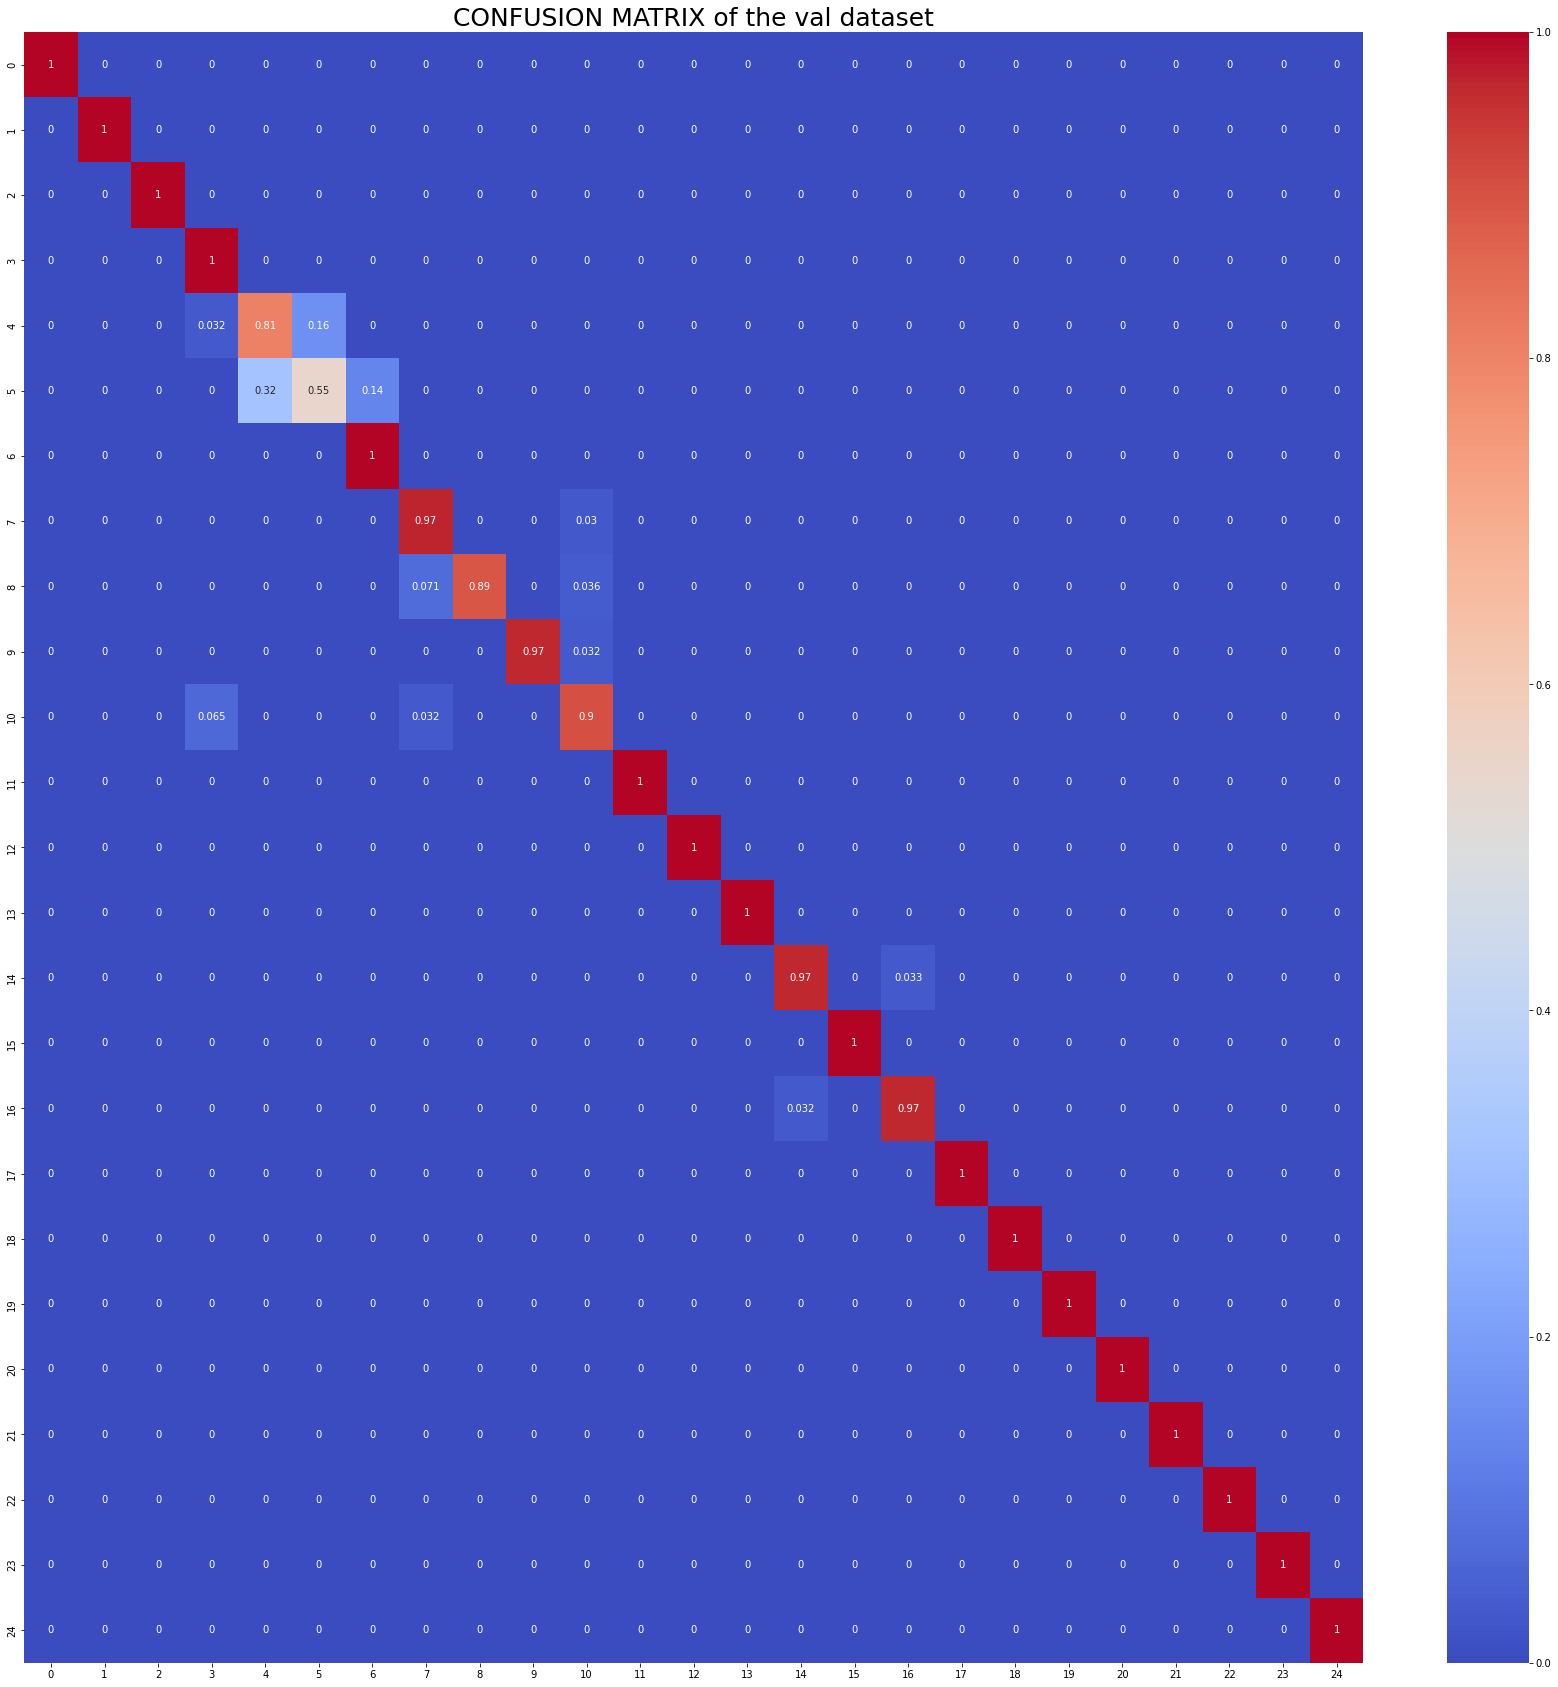

In [35]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(30, 30))
sns.heatmap(
    confusion_matrix(
        val_y_true,
        val_y_pred,
        normalize = 'true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the val dataset", fontsize=25)
plt.show()

# Test / 제출 파일 생성

In [36]:
# def predict(loader):
#     model.eval()
#     results = []

#     for batch, batch_item in enumerate(tqdm(loader)):
#         img = batch_item['img'].to(device)
#         seq = batch_item['csv_feature'].to(device)
#         with torch.no_grad():
#             output = model(img, seq)
#         output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
#         results.extend(output)    
#     return results

# model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=fc_dropout_rate)
# model.load_state_dict(torch.load(save_path, map_location=device))
# model.to(device)

# preds = predict(test_dataloader)
# # 25min

In [37]:
# preds = np.array([label_decoder[int(val)] for val in preds])

In [38]:
# submission = pd.read_csv('data/sample_submission.csv')
# submission['label'] = preds
# submission

In [39]:
# submission.to_csv(f'{save_name}_{np.max(val_score_list):.6f}.csv', index=False)